In [2]:
import os, time, csv
from pathlib import Path
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

# Prepare dataset (ImageFolder)
DATA_ROOT = "data_subset/split"  # expects train/val/test/<class>/*.jpg
IMG_SIZE  = 224
BATCH_SIZE = 16
NUM_WORKERS = 2

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

tfm_train = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.6, 1.0), ratio=(0.8, 1.25)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2))
])
tfm_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=tfm_train)
val_data   = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=tfm_eval)
test_data  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=tfm_eval)

classes = train_data.classes

targets = [y for _, y in train_data.samples]
binc = np.bincount(targets)
weights = 1.0 / np.maximum(binc, 1)
sample_w = np.array([weights[t] for t in targets], dtype=np.float64)
sampler = WeightedRandomSampler(torch.as_tensor(sample_w), num_samples=len(sample_w), replacement=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"Classes: {classes}")
print(f"Train/Val/Test sizes: {len(train_data)}, {len(val_data)}, {len(test_data)}")

Device: cpu
Classes: ['Angry', 'Happy', 'Sad', 'Tired']
Train/Val/Test sizes: 4395, 934, 927


In [5]:
def get_model(name: str, num_classes: int) -> nn.Module:
    n = name.lower()
    if n in ["mobilenetv3", "mobilenet_v3_small"]:
        m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        m.classifier[3] = nn.Linear(m.classifier[3].in_features, num_classes)
        return m
    elif n in ["efficientnet_b0", "efficientnet_lite0"]:
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        return m
    elif n == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m
    else:
        raise ValueError(f"Unknown model: {name}")

In [6]:
def evaluate(model: nn.Module, loader: DataLoader, device: str):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    crit = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += crit(logits, y).item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum/total, correct/total

def train_one(model, dl_train, dl_val, epochs, lr, patience, device, out_ckpt: Path, classes: list):
    opt = optim.Adam(model.parameters(), lr=lr)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    crit = nn.CrossEntropyLoss()
    best_acc, wait = -1.0, 0
    for ep in range(1, epochs+1):
        model.train()
        ep_loss, n = 0.0, 0
        for x,y in dl_train:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * y.size(0)
            n += y.size(0)
        train_loss = ep_loss / n
        val_loss, val_acc = evaluate(model, dl_val, device)
        sched.step()
        if val_acc > best_acc + 1e-4:
            best_acc = val_acc
            torch.save({"state_dict": model.state_dict(), "classes": classes}, out_ckpt)
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
    return best_acc

In [ ]:
OUT_DIR = Path("outputs_a2"); OUT_DIR.mkdir(exist_ok=True, parents=True)
BACKBONES = ["mobilenetv3", "efficientnet_b0", "resnet18"]
EPOCHS, LR, PATIENCE = 10, 5e-4, 4

summary_rows = []
for name in BACKBONES:
    ckpt_path = OUT_DIR / f"best_{name}.pth"
    model = get_model(name, num_classes=len(classes)).to(device)
    best_val = train_one(model, train_loader, val_loader, EPOCHS, LR, PATIENCE, device, ckpt_path, classes)

    # reload best
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model = get_model(name, num_classes=len(ckpt.get('classes', classes))).to(device)
    model.load_state_dict(ckpt["state_dict"])

    # test accuracy (FP32)
    _, acc_fp32 = evaluate(model, test_loader, device)

    # dynamic quantization
    q_path = OUT_DIR / f"best_{name}_quantized.pth"
    qmodel = torch.quantization.quantize_dynamic(model.cpu(), {nn.Linear}, dtype=torch.qint8).to(device)
    torch.save({"state_dict": qmodel.state_dict(), "classes": ckpt.get('classes', classes), "quantized": True}, q_path)

    # test accuracy (INT8)
    _, acc_int8 = evaluate(qmodel, test_loader, device)

    size_fp32 = os.path.getsize(ckpt_path)/(1024*1024)
    size_int8 = os.path.getsize(q_path)/(1024*1024)

    summary_rows.append((name, "FP32", round(acc_fp32,4), round(size_fp32,2)))
    summary_rows.append((name, "INT8", round(acc_int8,4), round(size_int8,2)))

print("Backbone | Kind | Acc | SizeMB")
for row in summary_rows:
    print(row[0], "|", row[1], "|", row[2], "|", row[3])

Backbone | Kind | Acc | SizeMB
mobilenetv3 | FP32 | 0.9979 | 5.93
mobilenetv3 | INT8 | 0.9979 | 4.24
efficientnet_b0 | FP32 | 0.9989 | 15.59
efficientnet_b0 | INT8 | 0.9989 | 15.58
resnet18 | FP32 | 0.9947 | 42.72
resnet18 | INT8 | 0.9947 | 42.71


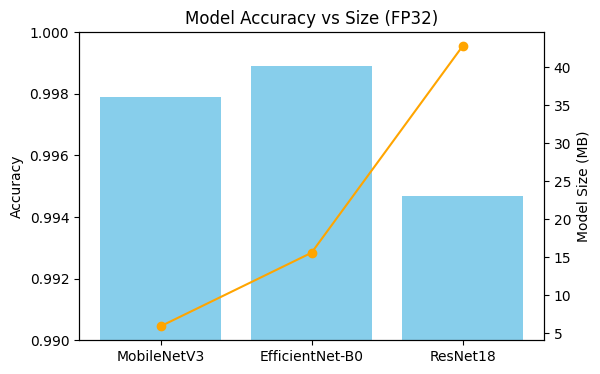

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Backbone": ["MobileNetV3", "EfficientNet-B0", "ResNet18"],
    "Accuracy_FP32": [0.9979, 0.9989, 0.9947],
    "SizeMB_FP32": [5.93, 15.59, 42.72]
}
df = pd.DataFrame(data)
fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()
ax1.bar(df["Backbone"], df["Accuracy_FP32"], color="skyblue", label="Accuracy")
ax2.plot(df["Backbone"], df["SizeMB_FP32"], color="orange", marker="o", label="Model Size (MB)")
ax1.set_ylabel("Accuracy"); ax2.set_ylabel("Model Size (MB)")
ax1.set_ylim(0.99, 1.0)
plt.title("Model Accuracy vs Size (FP32)")
plt.show()


In [ ]:
import time, psutil, numpy as np
from pathlib import Path

def to_cpu_loader(loader):
    # batch_size=1 tensors on CPU
    for x, y in loader:
        for i in range(x.size(0)):
            yield x[i:i+1].cpu(), y[i:i+1].cpu()

def load_fp32_cpu(name, num_classes, fp32_ckpt_path):
    model = get_model(name, num_classes)
    ckpt  = torch.load(fp32_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["state_dict"])
    model.eval().to("cpu")
    return model

def quantize_dynamic_linear_cpu(model):
    qmodel = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
    return qmodel.eval().to("cpu")

@torch.no_grad()
def bench_cpu(model, loader_cpu, warmup=20, iters=200):
    n = 0
    for x, _ in loader_cpu:
        _ = model(x)
        n += 1
        if n >= warmup: 
            break
    lat = []
    n = 0
    for x, _ in loader_cpu:
        t0 = time.perf_counter()
        _  = model(x)
        lat.append((time.perf_counter() - t0) * 1000.0)
        n += 1
        if n >= iters: 
            break
    lat = np.array(lat)
    cpu = psutil.cpu_percent(interval=0.5)
    mem = psutil.virtual_memory().percent
    return float(lat.mean()), float(lat.std()), float(np.percentile(lat, 95)), cpu, mem

names = ["mobilenetv3", "efficientnet_b0", "resnet18"]
for name in names:
    fp32_ckpt = Path(f"outputs_a2/best_{name}.pth")
    model_fp32 = load_fp32_cpu(name, len(classes), fp32_ckpt)
    model_int8 = quantize_dynamic_linear_cpu(model_fp32)

    # batch=1, CPU-only loader
    cpu_loader = to_cpu_loader(test_loader)

    m_fp32, s_fp32, p95_fp32, cpu_fp32, mem_fp32 = bench_cpu(model_fp32, cpu_loader, iters=120)
    cpu_loader = to_cpu_loader(test_loader)
    m_int8, s_int8, p95_int8, cpu_int8, mem_int8 = bench_cpu(model_int8, cpu_loader, iters=120)

    print(f"{name:15s} | FP32  {m_fp32:7.2f}±{s_fp32:5.2f} ms (p95 {p95_fp32:7.2f}) | CPU {cpu_fp32:4.1f}% | Mem {mem_fp32:4.1f}%")
    print(f"{'':15s} | INT8  {m_int8:7.2f}±{s_int8:5.2f} ms (p95 {p95_int8:7.2f}) | CPU {cpu_int8:4.1f}% | Mem {mem_int8:4.1f}%")

mobilenetv3     | FP32    61.94±38.67 ms (p95  142.27) | CPU  0.0% | Mem 75.7%
                | INT8    28.39±13.41 ms (p95   59.37) | CPU  0.0% | Mem 75.5%
efficientnet_b0 | FP32   101.65±23.00 ms (p95  143.98) | CPU  1.0% | Mem 75.3%
                | INT8    98.49±13.54 ms (p95  136.38) | CPU  0.0% | Mem 73.7%
resnet18        | FP32    81.69±12.25 ms (p95  119.96) | CPU  1.0% | Mem 74.0%
                | INT8   108.54±37.75 ms (p95  178.78) | CPU  7.5% | Mem 73.7%


              precision    recall  f1-score   support

       Angry      1.000     0.979     0.989        95
       Happy      1.000     1.000     1.000       160
         Sad      0.986     1.000     0.993       141
       Tired      1.000     1.000     1.000       531

    accuracy                          0.998       927
   macro avg      0.997     0.995     0.996       927
weighted avg      0.998     0.998     0.998       927



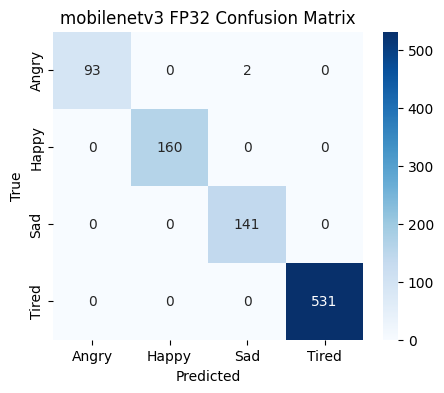

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

OUT_DIR = Path("outputs_a2"); OUT_DIR.mkdir(exist_ok=True, parents=True)

@torch.no_grad()
def collect_preds(model, loader, device):
    y_true, y_pred = [], []
    model.eval()
    for x,y in loader:
        x = x.to(device)
        logits = model(x)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())
    return np.array(y_true), np.array(y_pred)

name = "mobilenetv3"
ckpt_path = OUT_DIR / f"best_{name}.pth"
model_fp32 = get_model(name, len(classes)).to(device); model_fp32.load_state_dict(torch.load(ckpt_path, map_location="cpu")["state_dict"])

yt, yp = collect_preds(model_fp32, test_loader, device)
print(classification_report(yt, yp, target_names=classes, digits=3))

cm = confusion_matrix(yt, yp)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"{name} FP32 Confusion Matrix"); plt.show()
